In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf as pdf
import numpy as np
import pandas as pd
import colors as EL
import math, os
import more_itertools as mit

In [2]:
fps = 2
sh = 1 # direction in which to shift vector for delta calculations
threshold = 2 # consecutive seconds spent moving
still_threshold = 10 # seconds for minimum still num count
angle_thresh = 20 # Allowed error from previous angle
sharp_angle = 45
spiral_thresh = 4
spiral_speed_thresh = np.inf

animal = '190806-01-a-top'

In [3]:
def make_figure(animal):
    fig = plt.figure(figsize = (8, 3))
    ax = fig.add_subplot(111, aspect="equal")
    
    filename = "./data/trajectories/video_calculations/"+animal+'.csv'
    temp = pd.read_csv(filename)
    alpha=0.25
    ax.plot(temp['pos_x_mm'], temp['pos_y_mm'], color='k', 
            lw=2, alpha=alpha, zorder=0)
    
    # Set boundaries of the figure
    ax.set_xlim(0, 80)
    ax.set_ylim(30, 0)
    
    # Remove padding and margins from the figure and all its subplots
    plt.margins(0,0)
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    
    return fig, ax, temp

def save_figure(fig, ax, savename):
    # Save the Matplotlib figure as a PDF file:
    pp = pdf.PdfPages(savename, keep_empty=False)
    pp.savefig(fig)
    pp.close()
    # Show the figure
    plt.show() 

Number of spirals: 3


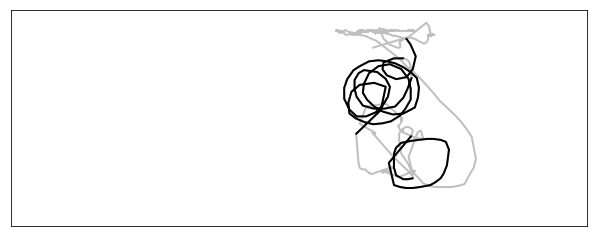

In [4]:
# Plot spirals
fig, ax, temp = make_figure(animal)
spiral_color = 'k'

# Get the change in the change in angle 
temp['angle_delta_2'] = temp['angle_delta'].shift(sh)
temp['angle_delta_delta'] = temp['angle_delta']-temp['angle_delta_2']
temp['angle_delta_delta'] = np.abs(temp['angle_delta_delta'])
temp_move = temp[temp["moving"] == True]
temp_move_side1 = temp_move[temp_move['angle_delta'] < 0]
temp_move_side2 = temp_move[temp_move['angle_delta'] > 0]

# Number of slow-moving spirals
timestamps1 = [list(x) for x in mit.consecutive_groups(temp_move_side1.index)]
timestamps2 = [list(x) for x in mit.consecutive_groups(temp_move_side2.index)]
timestamps1 = [x for x in timestamps1 if len(x) > spiral_thresh*fps]
timestamps2 = [x for x in timestamps2 if len(x) > spiral_thresh*fps]
small_spirals, small_spiral_len, total_timestamps = 0, [], []
for thresh_time in timestamps1+timestamps2: 
    thresh_time = [thresh_time[0]-1]+thresh_time
    df_thresh = temp[temp.index.isin(thresh_time)]
    if np.mean(df_thresh['speed_mm_s']) < spiral_speed_thresh:
        ax.plot(df_thresh['pos_x_mm'], df_thresh['pos_y_mm'], 
            color=spiral_color, zorder=2, lw=2, 
            solid_joinstyle='round', solid_capstyle='round')
        small_spirals += 1

print('Number of spirals:', small_spirals)
save_figure(fig, ax, './figures/2_spiral.pdf')

Number of continuous runs: 31


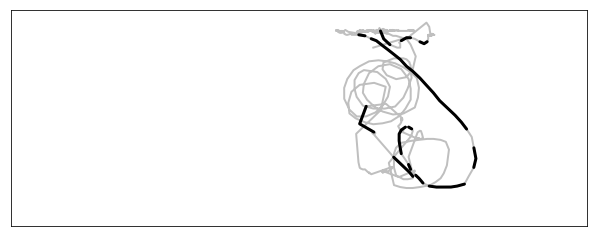

In [5]:
# Plot continuous runs
fig, ax, temp = make_figure(animal)
straight_color = 'k'

# Get the change in the change in angle 
temp['angle_delta_2'] = temp['angle_delta'].shift(sh)
temp['angle_delta_delta'] = temp['angle_delta']-temp['angle_delta_2']
temp['angle_delta_delta'] = np.abs(temp['angle_delta_delta'])
temp_move = temp[temp["moving"] == True]
temp_move_side1 = temp_move[temp_move['angle_delta'] < 0]
temp_move_side2 = temp_move[temp_move['angle_delta'] > 0]

# Number of slow-moving spirals
timestamps1 = [list(x) for x in mit.consecutive_groups(temp_move_side1.index)]
timestamps2 = [list(x) for x in mit.consecutive_groups(temp_move_side2.index)]
timestamps1 = [x for x in timestamps1 if len(x) > spiral_thresh*fps]
timestamps2 = [x for x in timestamps2 if len(x) > spiral_thresh*fps]
small_spirals, small_spiral_len, total_timestamps = 0, [], []
for thresh_time in timestamps1+timestamps2: 
    thresh_time = [thresh_time[0]-1]+thresh_time
    df_thresh = temp[temp.index.isin(thresh_time)]
    if np.mean(df_thresh['speed_mm_s']) < spiral_speed_thresh:
        total_timestamps += df_thresh['frames'].tolist()
        
# Number of continuous paths that are not spirals
temp_move_cons = temp_move[temp_move['angle_delta_delta'] <= angle_thresh]
timestamps = [list(x) for x in mit.consecutive_groups(temp_move_cons.index)]
continuous_nums = 0
for thresh_time in timestamps: 
    thresh_time = [thresh_time[0]-1]+thresh_time
    df_thresh = temp[temp.index.isin(thresh_time)]
    df_thresh = df_thresh[~df_thresh['frames'].isin(total_timestamps)]
    ax.plot(df_thresh['pos_x_mm'], df_thresh['pos_y_mm'], 
            color=straight_color, zorder=1, lw=3, 
                solid_joinstyle='round', solid_capstyle='round')
    continuous_nums += 1

print('Number of continuous runs:', continuous_nums)
save_figure(fig, ax, './figures/2_continuous.pdf')

807.0 seconds of stillness
90.5 seconds of movement
10.083565459610028 % of time spent moving
89.91643454038997 % of time spent still


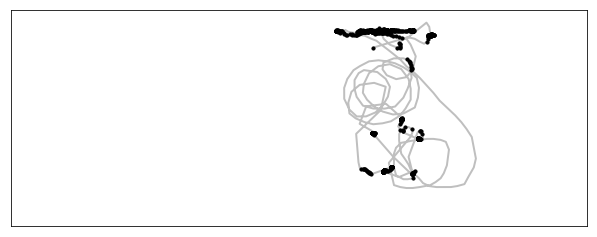

In [6]:
fig, ax, temp = make_figure(animal)

temp_move = temp[temp["moving"] == False]
print(len(temp_move)/2, 'seconds of stillness')
print(len(temp)/2-len(temp_move)/2, 'seconds of movement')
print(100-100*len(temp_move)/len(temp), '% of time spent moving')
print(100*len(temp_move)/len(temp), '% of time spent still')

ax.scatter(temp_move['pos_x_mm'], temp_move['pos_y_mm'], 
            color='k', s=10, zorder=20)
        
save_figure(fig, ax, './figures/2_timemove.pdf')

0.07746810810404582 mean speed


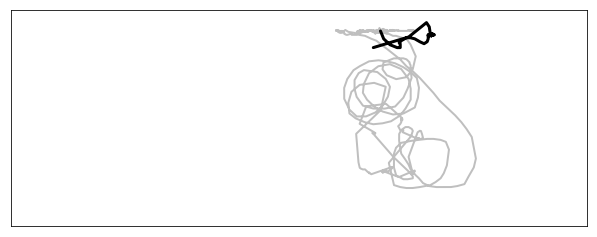

In [7]:
fig, ax, temp = make_figure(animal)
color = 'k'

mean_speed_first = temp[temp['frames'] <= 60*fps]['speed_BL'].mean()
df_thresh = temp[temp['frames'] <= 60*fps]

print(mean_speed_first, 'mean speed')
ax.plot(df_thresh['pos_x_mm'], df_thresh['pos_y_mm'], 
            color=straight_color, zorder=1, lw=3, 
                solid_joinstyle='round', solid_capstyle='round')  

save_figure(fig, ax, './figures/2_first.pdf')

-0.06742453842998009 mean speed (first) - mean speed (last)


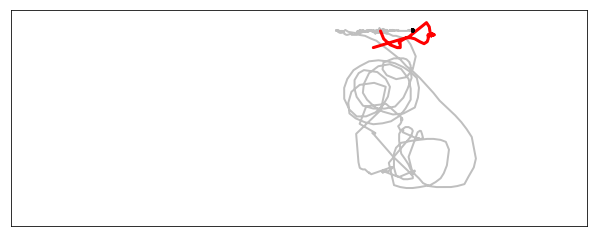

In [8]:
fig, ax, temp = make_figure(animal)

df_thresh = temp[temp['frames'] <= 60*fps]
mean_speed_first = df_thresh['speed_BL'].mean()
ax.plot(df_thresh['pos_x_mm'], df_thresh['pos_y_mm'], 
            color='r', zorder=1, lw=3, 
                solid_joinstyle='round', solid_capstyle='round')  

df_thresh_2 = temp[temp['frames'] >= 14*60*fps]
mean_speed_last = df_thresh_2['speed_BL'].mean()
ax.plot(df_thresh_2['pos_x_mm'], df_thresh_2['pos_y_mm'], 
            color='k', zorder=1, lw=3, 
                solid_joinstyle='round', solid_capstyle='round')  

print(mean_speed_last - mean_speed_first, 
      'mean speed (first) - mean speed (last)')

save_figure(fig, ax, './figures/2_firstlast.pdf')

0.3808968497297109 Total distance (m)


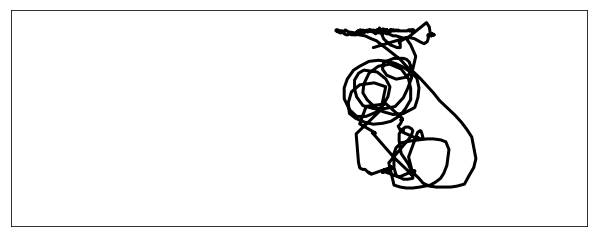

In [9]:
fig, ax, temp = make_figure(animal)

ax.plot(temp['pos_x_mm'], temp['pos_y_mm'], 
            color='k', zorder=1, lw=3, 
                solid_joinstyle='round', solid_capstyle='round') 

total_dist = temp['speed_mm_s'].sum()/fps/1000
print(total_dist, 'Total distance (m)')
save_figure(fig, ax, './figures/2_totaldist.pdf')

0.460818094253443 mean speed (BL)


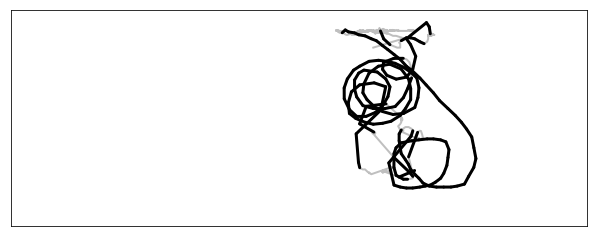

In [10]:
# Plot continuous runs
fig, ax, temp = make_figure(animal)

temp_move = temp[temp["moving"] == True]

for thresh_time in temp_move.index.tolist(): 
    thresh_time = [thresh_time-1, thresh_time]
    df_thresh = temp_move[temp_move.index.isin(thresh_time)]
    ax.plot(df_thresh['pos_x_mm'], df_thresh['pos_y_mm'], 
            color='k', zorder=1, lw=3, 
                solid_joinstyle='round', solid_capstyle='round')

if len(temp_move) == 0:
    avg_speed = 0
else:
    avg_speed = temp_move['speed_BL'].mean()
print(avg_speed, 'mean speed (BL)')
save_figure(fig, ax, './figures/2_mean_speed.pdf')

6.629834254143646 % of time spent making sharp turns


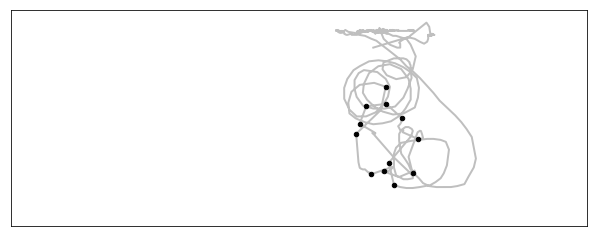

In [14]:
fig, ax, temp = make_figure(animal)
color = 'k'

temp_sharp = temp[temp['speed_mm_s'] > 4]
temp_sharp = temp_sharp[(temp_sharp['angle_delta'] < -sharp_angle) | \
                        (temp_sharp['angle_delta'] > sharp_angle)]
temp_sharp = [x-1 for x in temp_sharp['frames'].tolist()]
temp_sharp = temp[temp['frames'].isin(temp_sharp)]
sharp_turns = len(temp_sharp)*100/len(temp_move)

ax.scatter(temp_sharp['pos_x_mm'], temp_sharp['pos_y_mm'], 
            color=color, zorder=1, s=20)

print(sharp_turns, '% of time spent making sharp turns')

save_figure(fig, ax, './figures/2_sharp turns.pdf')

388.0 seconds max rest length
7


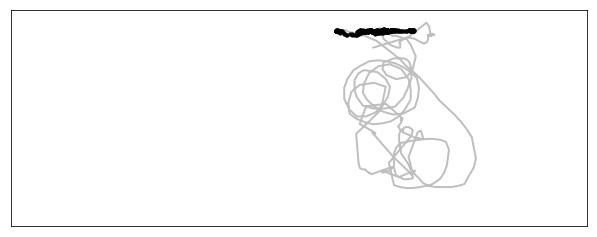

In [12]:
fig, ax, temp = make_figure(animal)

temp_still = temp[temp["moving"] == False]
timestamps = [list(x) for x in mit.consecutive_groups(temp_still.index)]
thresh_times = [x for x in timestamps if len(x) > still_threshold*fps]
thresh_lengths = [len(x) for x in thresh_times]
print((max(thresh_lengths)+1)/2, 'seconds max rest length')

inds = thresh_lengths.index(max(thresh_lengths))
print(inds)
df_thresh = temp[temp.index.isin(thresh_times[inds])]
ax.scatter(df_thresh['pos_x_mm'], df_thresh['pos_y_mm'], 
            color='k', zorder=1, s=10)

save_figure(fig, ax, './figures/2_maxrest.pdf')

1.7110766882601094


,frames,measurement_x,measurement_y,objid,position_x,position_y,pixel_width,pixel_height,manual_tracker_fix,larvae_length_mm,...,pos_y_mm,speed_mm_s,speed_BL,angle_counterclock,angle_delta,bin_ID,concentration,concentration_delta,moving,turn
1,6,391.0,25.0,0,384.166667,27.166667,556,220,False,6.0,...,3.704545,10.26646,1.711077,-16.725465,NaN,bin_295,1.081,0.256,True,False


[6, 5]


,frames,measurement_x,measurement_y,objid,position_x,position_y,pixel_width,pixel_height,manual_tracker_fix,larvae_length_mm,...,pos_y_mm,speed_mm_s,speed_BL,angle_counterclock,angle_delta,bin_ID,concentration,concentration_delta,moving,turn
0,5,350.0,38.0,0,350.000000,38.000000,556,220,False,6.0,...,5.181818,NaN,NaN,NaN,NaN,bin_450,0.825,NaN,False,False
1,6,391.0,25.0,0,384.166667,27.166667,556,220,False,6.0,...,3.704545,10.26646,1.711077,-16.725465,NaN,bin_295,1.081,0.256,True,False


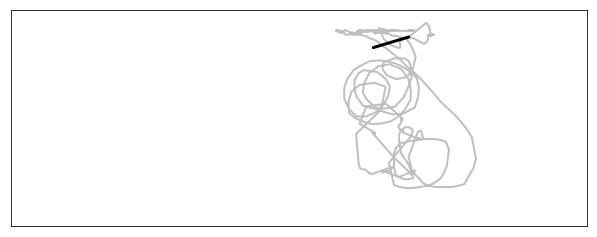

In [13]:
fig, ax, temp = make_figure(animal)

print(temp['speed_BL'].max())
temp2 = temp[temp['speed_BL'] == temp['speed_BL'].max()]
display(temp2.head())
ind = temp2.frames.tolist()
inds = [ind[0], ind[0]-1]
print(inds)

df_thresh = temp[temp['frames'].isin(inds)]
display(df_thresh.head())
ax.plot(df_thresh['pos_x_mm'], df_thresh['pos_y_mm'], 
            color=straight_color, zorder=1, lw=3, 
                solid_joinstyle='round', solid_capstyle='round')  

save_figure(fig, ax, './figures/2_maxspeed.pdf')